# `R`ecurrent `N`eural `N`etwork（循环神经网络）
基础<br>
https://blog.csdn.net/Yellow_python/article/details/86650810
<br>多序列预测<br>
https://blog.csdn.net/Yellow_python/article/details/86668140
<br>时序生成器<br>
https://blog.csdn.net/Yellow_python/article/details/86742440
<br>文本分析<br>
https://blog.csdn.net/Yellow_python/article/details/86707663

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')  # 不打印警告
import numpy as np, matplotlib.pyplot as mp
%matplotlib inline

## RNN的state

In [2]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, SimpleRNN, LSTM, GRU

x = np.reshape([1, 1], (1, 2, 1))

units = 4
rnn_ls = [
    ['SimpleRNN', SimpleRNN(units, return_sequences=True, return_state=True)],
    ['LSTM', LSTM(units, return_sequences=True, return_state=True)],
    ['GRU', GRU(units, return_sequences=True, return_state=True)]]

for path, rnn in rnn_ls:
    t_input = Input(shape=(2, 1))
    t_output_ls = rnn(t_input)
    model = Model(t_input, t_output_ls, name=path)
    model.summary()
    # 打印RNN输出
    t_output_ls = model.predict(x)
    for t_output in t_output_ls:
        print('\033[035m', t_output, t_output.shape)
    print('\033[0m')

Model: "SimpleRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 1)]            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       [(None, 2, 4), (None, 4)] 24        
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________
 [[[ 0.3927615  -0.2115294  -0.5705995  -0.2965945 ]
  [ 0.6739122  -0.14670981 -0.85331076 -0.05739556]]] (1, 2, 4)
 [[ 0.6739122  -0.14670981 -0.85331076 -0.05739556]] (1, 4)

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  [(None, 2, 4), (None, 4), 96        
T

## 手写数字识别

In [3]:
from tensorflow.python.keras.datasets import mnist  # 手写数字0-9
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.models import Sequential  # 顺序模型
from tensorflow.python.keras.layers import SimpleRNN, Dense

"""数据读取和预处理"""
(x, y), _ = mnist.load_data()
x = x / 255  # 像素值→[0,1]
y = to_categorical(y, 10)  # one-hot编码

"""建模"""
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(28, 28)))  # RNN
model.add(Dense(units=10, activation='softmax'))  # 输出层

"""编译"""
model.compile('adam', 'categorical_crossentropy', ['acc'])

"""拟合、取10%样本来验证"""
model.fit(x, y, batch_size=256, epochs=5, verbose=2, validation_split=.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 - 4s - loss: 1.0096 - acc: 0.6886 - val_loss: 0.4825 - val_acc: 0.8605
Epoch 2/5
48000/48000 - 3s - loss: 0.4220 - acc: 0.8756 - val_loss: 0.3127 - val_acc: 0.9123
Epoch 3/5
48000/48000 - 3s - loss: 0.3174 - acc: 0.9074 - val_loss: 0.2695 - val_acc: 0.9217
Epoch 4/5
48000/48000 - 3s - loss: 0.2669 - acc: 0.9229 - val_loss: 0.2372 - val_acc: 0.9317
Epoch 5/5
48000/48000 - 3s - loss: 0.2387 - acc: 0.9309 - val_loss: 0.2335 - val_acc: 0.9317


## 余弦曲线拟合

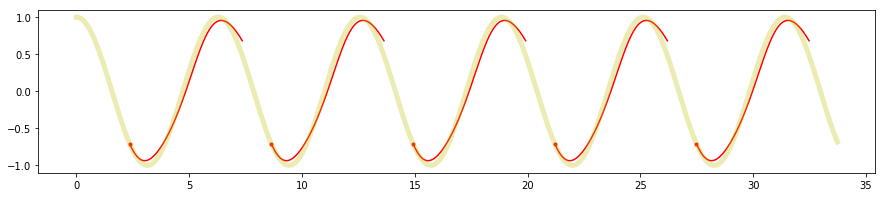

In [4]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM

"""创建样本"""
x_len = 1075
x = np.linspace(0, np.pi * 10.75, x_len, endpoint=False)
y = np.cos(x)
window = 75  # 时序滑窗大小
X = [y[i: i + window] for i in range(x_len - window)]
X = np.reshape(X, (-1, window, 1))  # shape (1000, 75, 1)
Y = y[window:].reshape(-1, 1)  # shape (1000, 1)

"""建模"""
model = Sequential()
model.add(LSTM(units=50, input_shape=X.shape[1:], return_sequences=True))  # True返回输出序列的全部
model.add(LSTM(units=100, return_sequences=False))  # False返回输出序列的最后一个
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')  # 均方误差（Mean Square Error）
model.fit(X, Y, batch_size=100, epochs=10, verbose=0)

"""预测"""
mp.figure(figsize=[15, 3])
pred_len = 160  # 预测序列长度
for start in range(0, 1000, 200):
    x_pred = x[window + start: window + start + pred_len]
    y_pred = []  # 存放拟合序列
    X_pred = X[start]
    for i in range(pred_len):
        Y_pred = model.predict(X_pred.reshape(-1, window, 1))  # 预测
        y_pred.append(Y_pred[0])
        X_pred = np.concatenate((X_pred, Y_pred))[1:]  # 窗口滑动
    mp.scatter(x_pred[0], y_pred[0], c='r', s=9)  # 预测起始点
    mp.plot(x_pred, y_pred, 'r')  # 预测序列
mp.plot(x, y, 'y', linewidth=5, alpha=0.3)  # 原序列
mp.show()

## 多序列预测

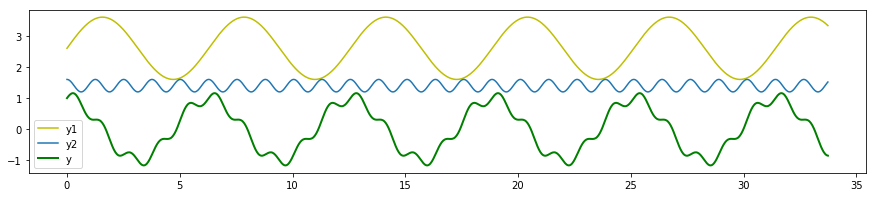

In [5]:
mp.figure(figsize=[15, 3])
x_len = 1075
x = np.linspace(0, np.pi * 10.75, x_len, endpoint=False)
y = np.cos(x) + np.sin(x * 5) * .2  # y是由y1和y2组成
y1 = np.sin(x) + 2.6
y2 = np.cos(x * 5) * .2 + 1.4
mp.plot(x, y1, 'y', label='y1')
mp.plot(x, y2, label='y2')
mp.plot(x, y, 'g', label='y', linewidth=2)
mp.legend()
mp.show()

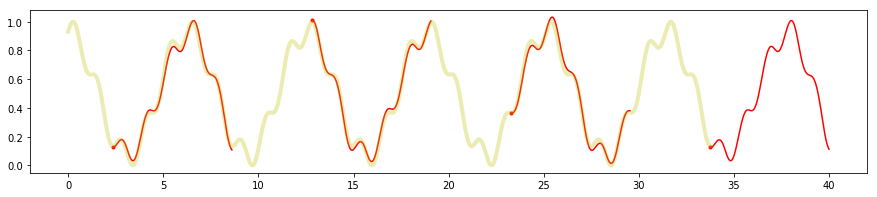

In [6]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

"""创建样本"""
x_len = 1075
x = np.linspace(0, np.pi * 10.75, x_len, endpoint=False)
y = np.array([[np.sin(x[i] * 5) * .2 + np.cos(x[i]),
               np.cos(x[i] * 5) * .2,
               np.sin(x[i])] for i in range(x_len)])  # shape(1075, 3)
y = MinMaxScaler().fit_transform(y)  # 标准化
d = y.shape[1]  # 维度（dimension）
window = 75  # 时序滑窗大小
X = np.array([[[y[j, k] for k in range(d)] for j in range(i, i + window)]
              for i in range(x_len - window)])  # shape(1000, 75, 3)
Y = np.array([[y[i, k] for k in range(d)]
              for i in range(window, x_len)])  # shape(1000, 3)

"""建模"""
model = Sequential()
model.add(LSTM(50, input_shape=(window, d), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(d))
model.compile('adam', 'mse')
model.fit(X, Y, batch_size=100, epochs=10, verbose=0)

"""预测"""
mp.figure(figsize=[15, 3])
pred_len = 200  # 预测序列长度
for start in (0, 333, 666, 999):
    x_pred = np.linspace(np.pi * (window + start) / 100,
                         np.pi * (window + start + pred_len) / 100,
                         pred_len, endpoint=False)
    y_pred = []  # 存放预测序列
    X_pred = X[start]
    for i in range(pred_len):
        Y_pred = model.predict(X_pred.reshape(1, window, d))  # shape(1, 3)
        y_pred.append(Y_pred[0][0])
        X_pred = np.concatenate((X_pred, Y_pred))[1:]  # 窗口滑动
    mp.scatter(x_pred[0], y_pred[0], c='r', s=9)  # 预测起始点
    mp.plot(x_pred, y_pred, 'r')  # 预测序列
mp.plot(x, y[:, 0], 'y', linewidth=4, alpha=.3)  # 原序列
mp.show()

## 时序生成器

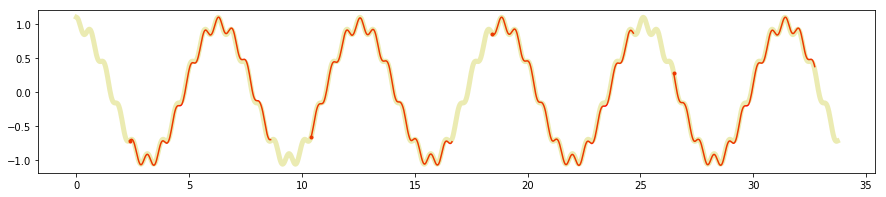

In [7]:
from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv1D, MaxPool1D, GRU

"""配置"""
x_len = 1075
window = 75  # 时序滑窗大小
filters = 64  # 滤波器数量
kernel_size = 9  # 滤波器大小
units = 64  # RNN神经元数量
batch_size = 256
epochs = 50

"""创建样本"""
x = np.linspace(0, np.pi * 10.75, x_len, endpoint=False)
y = (np.cos(x) + np.cos(x * 10) * .1).reshape(-1, 1)
tg = TimeseriesGenerator(y, y, length=window, batch_size=batch_size)

"""建模"""
model = Sequential()
model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(window, 1)))
model.add(MaxPool1D())
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GRU(units))  # 门限循环单元网络
model.add(Dense(1))

# 编译、训练
model.compile('adam', 'mse')
model.fit_generator(tg, epochs=epochs, verbose=0)

"""预测"""
mp.figure(figsize=[15, 3])
pred_len = 200  # 预测序列长度
for i in range(4):
    x_pred = x[i * batch_size + window: i * batch_size + window + pred_len]
    y_pred = []  # 存放拟合序列
    X_pred = tg[i][0][0]
    for i in range(pred_len):
        Y_pred = model.predict(X_pred.reshape(-1, window, 1))  # 预测
        y_pred.append(Y_pred[0])
        X_pred = np.concatenate((X_pred, Y_pred))[1:]  # 窗口滑动
    mp.scatter(x_pred[0], y_pred[0], c='r', s=9)  # 预测起始点
    mp.plot(x_pred, y_pred, 'r')  # 预测序列
mp.plot(x, y, 'y', linewidth=5, alpha=0.3)  # 原序列
mp.show()